# Hyperparameter search for Non-Sequential Electricity Price Forecasting Pipeline

This notebook provides the full implementation for the hyperparameter search discussed in our talk at deRSE23.
To recap the scenario, we apply a GridSearch from sklearn to a non-sequential pipeline that predicts the electricity price of the next day based on calendar information, historical information, and a 48 hour load forecast.

### Setting up the Pipeline
Before we start defining the pipeline, we import the necessary dependencies.

In [1]:
import pandas as pd
from pywatts.callbacks import LinePlotCallback
from pywatts.modules import CalendarExtraction, CalendarFeature, SKLearnWrapper
from pywatts.modules.preprocessing.select import Select
from pywatts.summaries import RMSE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.load_data import load_elec_data
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode
import warnings
warnings.filterwarnings('ignore')

Now we can create a pipeline. We consider the following simple forecasting scenario where we aim to forecast the day-ahead electricity price. Since the electricity price is dependent on the electrical demand, we create a pipeline that forecasts the electricity demand and uses this forecast as an input for the electricity price forecast. As additional information, we use calendar features.
So we use the following elements in the pipeline defined below:
* CalendarExtraction
* Scaler for the Electricity price
* Scaler for the Electricity demand
* Forecaster for the Electricity price
* Forecaster for the Electricity demand


In [2]:
# Create a pipeline
pipeline = Pipeline(path="../results")

# Extract dummy calendar features, using holidays from Germany
calendar = CalendarExtraction(continent="Europe",
                              country="Germany",
                              features=[CalendarFeature.month,CalendarFeature.weekday,
                                        CalendarFeature.weekend],
                              name="calendar"
                              )(x=pipeline["load_power_statistics"])

# We select samples for calendar features. For the load we consider the next 24 hours, for the price, the next 48 hours.
calendar_load = Select(start=0, stop=24, step=1)(x=calendar)
calendar_price = Select(start=0, stop=48, step=1)(x=calendar)

# Scale the data using a standard SKLearn scaler
power_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_power")
scale_power = power_scaler(x=pipeline["load_power_statistics"])

price_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_price")
scale_price = price_scaler(x=pipeline["price_day_ahead"])

# Create lagged time series to later be used as regressors
lag_features_load = Select(start=-24, stop=0, step=1, name="lag_features_load")(x=scale_power)
lag_features_price = Select(start=-24, stop=0, step=1, name="lag_features_price")(x=scale_price)

target_load = Select(start=0, stop=48, step=1, name="load_hist")(x=scale_power)
target_price = Select(start=0, stop=24, step=1, name="price_hist")(x=scale_price)

# We also select samples for the target
target_price_unscaled = Select(start=0, stop=24, step=1, name="target")(x=pipeline["price_day_ahead"])

# Create a linear regression that uses the lagged values to predict the current value
# NOTE: SKLearnWrapper has to collect all **kwargs itself and fit it against target.
#       It is also possible to implement a join/collect class
forecast_load = SKLearnWrapper(module=LinearRegression(fit_intercept=True), name="load_forecast")(
    features=lag_features_load,
    calendar=calendar_load,
    target=target_load,
)

# Now we also predict the price, based on the load forecast
forecast_price_scaled = SKLearnWrapper(module=LinearRegression(fit_intercept=True), name="price_forecast")(
    features=lag_features_price,
    calendar=calendar_price,
    load=forecast_load,
    target=target_price,
)

# Rescale the predictions to be on the original scale
forecast_price = price_scaler(
    x=forecast_price_scaled, computation_mode=ComputationMode.Transform,
    method="inverse_transform", callbacks=[LinePlotCallback("rescale")]
)

# Calculate the root mean squared error (RMSE) between the linear regression and the true values
rmse = RMSE(name="rmse")(y_hat=forecast_price, y=target_price_unscaled)

pyWATTS allows us to automatically visualise the defined pipeline. This is particularly useful as a sanity check to make sure the pipeline is actually constructed as we expect.

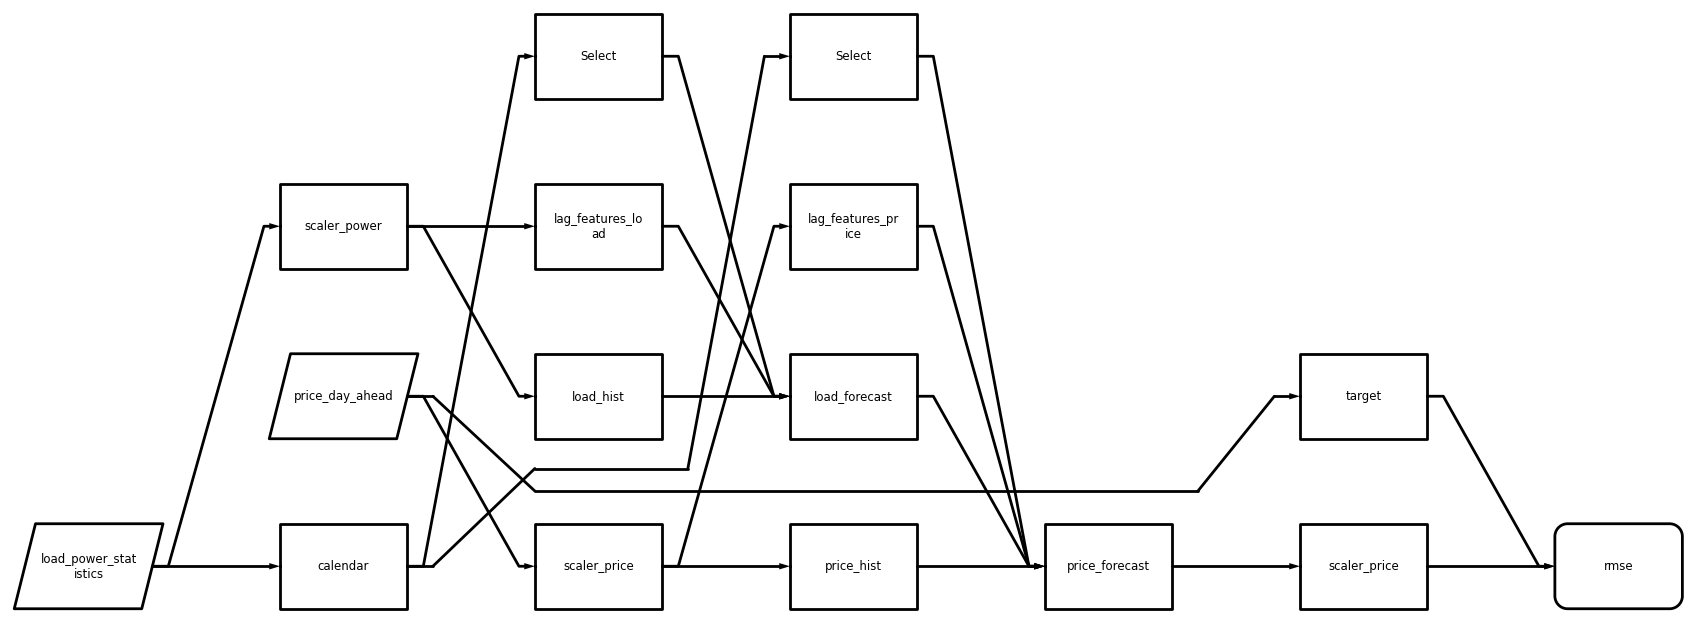

In [3]:
drawing = pipeline.draw()
drawing.draw()

Since we aim to perform hyperparameter optimisation, we also need to set a score to be used later. In this case, we select the RMSE and aim to minimise it.

In [4]:
pipeline.set_score("rmse", direction="lower")

### Reading in the Data
To train and evaluate the pipeline we need data. In this case we:
* Automatically load the data and create a train and test split.
* We use a subset of hourly electricity load values for the state of Baden-Württemberg in Germany, taken from the Open Power Systems Data portal.

In [5]:
# Load data
data = load_elec_data()

# Create train and test splits
train_data = data[:6000]
test_data = data[6000:]

### Setting up the Hyperparamter Optimisation
To apply hyperparameter optimisation, the parameter and the search space needs to be defined. For the GridCV hyperparameter search, we can use the sklearn interface, which is a dict that maps from a key to the possible parameter values, whereby each key is a parameter of the pipeline. Note that the double underscore `__` is a separator and indicates nesting. E.g., `calendar__features` is the key to the parameter features of the pipeline module called calendar.

In [6]:
params = {
    "load_forecast__module": [LinearRegression(), MLPRegressor()],
    "price_forecast__module": [LinearRegression(), MLPRegressor()],
    "scaler_power__module": [MinMaxScaler(), StandardScaler()],
    "scaler_price__module": [MinMaxScaler(), StandardScaler()],
    "calendar__features": [[CalendarFeature.month_cos, CalendarFeature.month_sine, CalendarFeature.weekend],
                           [CalendarFeature.hour_cos, CalendarFeature.hour_sine, CalendarFeature.weekend]],
}

We can now print out the parameters of the pipeline.

In [7]:
pipeline.get_params(deep=True)

{'steps': [[1,
   'calendar',
   {'x': 'load_power_statistics'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [2,
   'Select',
   {'x': 'calendar'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [3,
   'Select_1',
   {'x': 'calendar'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [4,
   'scaler_power',
   {'x': 'load_power_statistics'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [5,
   'scaler_price',
   {'x': '

### Training the Pipeline
To train the pipeline, we simply call the __pipeline.train()__ method.

In [6]:
result, summary = pipeline.train(data=train_data)
pipeline.score(test_data)

-12.725388816382365

### Performing Hyperparemter Optimisation

We can now perform the sklearn grid serach on the pipeline.
**NOTE - this step takes a long time (+20mins) to complete, so only start it if you are feeling patient**

In [9]:
tscv = TimeSeriesSplit(test_size=168*4)
pipeline_cv = GridSearchCV(pipeline, param_grid=params, cv=tscv)
pipeline_cv.fit(data)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=672),
             estimator=Pipeline(model_dict={1: CalendarExtraction(features=[<CalendarFeature.month: 2>,
                                                                            <CalendarFeature.weekday: 11>,
                                                                            <CalendarFeature.weekend: 21>],
                                                                  name='calendar'),
                                            2: Select(start=0, step=1, stop=24),
                                            3: Select(start=0, step=1, stop=48),
                                            4: SKLearnWrapper(module=StandardScal...
                                                 <CalendarFeature.weekend: 21>],
                                                [<CalendarFeature.hour_cos: 10>,
                                                 <CalendarFeature.hour_sine: 9>,
                                                 <CalendarFeature.weekend: 21>]],
                         'load_forecast__module': [LinearRegression(),
                                                   MLPRegressor()],
                         'price_forecast__module': [LinearRegression(),
                                                    MLPRegressor()],
                         'scaler_power__module': [MinMaxScaler(),
                                                  StandardScaler()],
                         'scaler_price__module': [MinMaxScaler(),
                                                  StandardScaler()]})

Now we can print out the identified best parameters.

In [10]:
pipeline_cv.best_params_

{'calendar__features': [<CalendarFeature.month_cos: 4>,
  <CalendarFeature.month_sine: 3>,
  <CalendarFeature.weekend: 21>],
 'load_forecast__module': LinearRegression(),
 'price_forecast__module': LinearRegression(),
 'scaler_power__module': MinMaxScaler(),
 'scaler_price__module': StandardScaler()}

And we can also print out a summary of all the search combinations.

In [11]:
pd.DataFrame(pipeline_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_calendar__features,param_load_forecast__module,param_price_forecast__module,param_scaler_power__module,param_scaler_price__module,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.447063,0.084174,0.439159,0.026171,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),LinearRegression(),MinMaxScaler(),MinMaxScaler(),{'calendar__features': [CalendarFeature.month_...,-6.258543,-14.142926,-11.912707,-10.513598,-13.981973,-11.361950,2.886733,3
1,0.423017,0.117836,0.427817,0.023916,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),LinearRegression(),MinMaxScaler(),StandardScaler(),{'calendar__features': [CalendarFeature.month_...,-6.259812,-14.141930,-11.905269,-10.512839,-13.983676,-11.360705,2.886165,1
2,0.725811,0.387334,0.448244,0.037521,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),LinearRegression(),StandardScaler(),MinMaxScaler(),{'calendar__features': [CalendarFeature.month_...,-6.259089,-14.143283,-11.909329,-10.513868,-13.981939,-11.361502,2.886459,2
3,0.376077,0.058336,0.459036,0.054746,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),LinearRegression(),StandardScaler(),StandardScaler(),{'calendar__features': [CalendarFeature.month_...,-6.279633,-14.142603,-11.908903,-10.513977,-13.982613,-11.365546,2.879167,4
4,2.922783,0.624999,0.344890,0.045453,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),MLPRegressor(),MinMaxScaler(),MinMaxScaler(),{'calendar__features': [CalendarFeature.month_...,-11.285374,-17.939045,-14.924565,-14.167721,-16.207412,-14.904823,2.215733,27
5,18.974030,4.484064,0.331508,0.009098,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),MLPRegressor(),MinMaxScaler(),StandardScaler(),{'calendar__features': [CalendarFeature.month_...,-11.475070,-14.191126,-15.627922,-20.050071,-15.091818,-15.287202,2.777514,30
6,3.227419,0.883887,0.330018,0.010015,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),MLPRegressor(),StandardScaler(),MinMaxScaler(),{'calendar__features': [CalendarFeature.month_...,-13.745745,-17.128590,-15.186025,-15.675400,-16.592917,-15.665736,1.176111,31
7,17.906524,7.690304,0.326793,0.004712,"[CalendarFeature.month_cos, CalendarFeature.mo...",LinearRegression(),MLPRegressor(),StandardScaler(),StandardScaler(),{'calendar__features': [CalendarFeature.month_...,-9.942036,-14.333758,-14.983547,-16.641544,-15.085910,-14.197359,2.258674,25
8,3.077913,1.200227,0.436773,0.024591,"[CalendarFeature.month_cos, CalendarFeature.mo...",MLPRegressor(),LinearRegression(),MinMaxScaler(),MinMaxScaler(),{'calendar__features': [CalendarFeature.month_...,-7.914919,-14.256763,-12.088937,-12.805564,-14.249340,-12.263105,2.330284,16
9,2.566916,0.733086,0.400316,0.025498,"[CalendarFeature.month_cos, CalendarFeature.mo...",MLPRegressor(),LinearRegression(),MinMaxScaler(),StandardScaler(),{'calendar__features': [CalendarFeature.month_...,-7.661043,-14.097459,-11.815329,-12.618371,-14.840887,-12.206618,2.509962,15


We hope this example helped you understand pyWATTS.